In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
#from tqdm.autonotebook import tqdm

In [19]:
#agent class

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #wealth is the total wealth, P-most probable money, m is the wealth
        #at each time step
        self.m = self.model.T
        self.lamda = random.random()
        
        

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position   = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        epsilon = random.random()
        if len(cellmates) > 1 :
            other = self.random.choice(cellmates)
            if(other.unique_id != self.unique_id):
                xi = self.m
                xj = other.m
                #print(xi, xj, xi+xj)
                delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_m
                xj_new = xj + delta_m
                other.m = xj_new
                self.m = xi_new
                self.model.trade+=1
                #print(xi_new, xj_new, xi_new+xj_new)
                #print("break")

    def step(self):
        if self.m > 0:
            self.give_money()
        self.move()

In [32]:
#model

#saving propensity = lamda
class BoltzmannWealthModel(Model):

    def __init__(self,T,N, width=10, height=10):
        self.num_agents = N
        self.T = T
        self.grid = MultiGrid(height, width, True)
        self.trade = 0
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {'trade': 'trade'},agent_reporters={ 'mi':'m', 'lamda':'lamda'})
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            #print("step:{}".format(i))
            self.step()
            self.trade = 0


In [33]:
N = 500 #number of agents
T = 100 #average money per agent
M = N*T #total_money
steps = 7000
model = BoltzmannWealthModel(T,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
#agent_df['Step'] = agent_df.index


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [34]:
#saving files
model_df.loc[1:].to_csv("Data\Model_Run1.csv")
agent_df['mt'] = agent_df.mi/T
agent_df.to_csv("Data\Agent_Run1.csv")

In [35]:
data = pd.read_csv("Data\Agent_Run1.csv")
data.head()

,Step,AgentID,mi,lamda,mt
0,0,0,100.0,0.774635,1.0
1,0,1,100.0,0.770924,1.0
2,0,2,100.0,0.709216,1.0
3,0,3,100.0,0.898537,1.0
4,0,4,100.0,0.319074,1.0


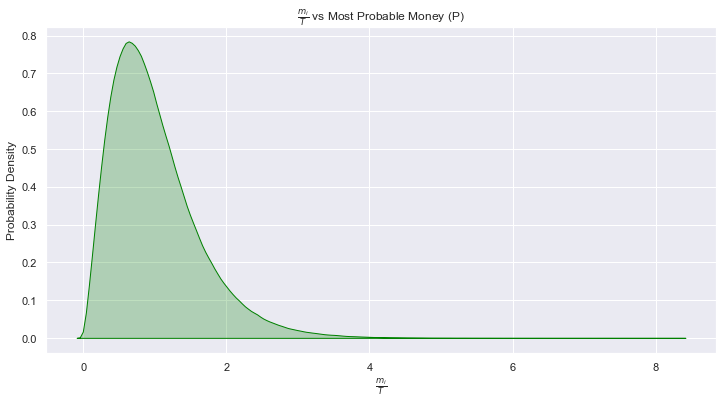

In [36]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data.mt, fill = True, color = 'green')
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability Density")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money (P)") 
plt.savefig("kdeplot_run1");

<h3> Capacity curve of an agent

In [51]:
def sigmoid(x, L ,x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

agent = random.randint(0,499)
xdata = data.loc[data['AgentID']==agent, 'mi'].reset_index(drop=True)
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]
xdata = xdata[0:100]
steps = (len(xdata))
ydata = xdata[1:]
xdata = xdata[0:len(xdata)-1]

p0 = [max(ydata), sum(xdata)/len(xdata),0.2] # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

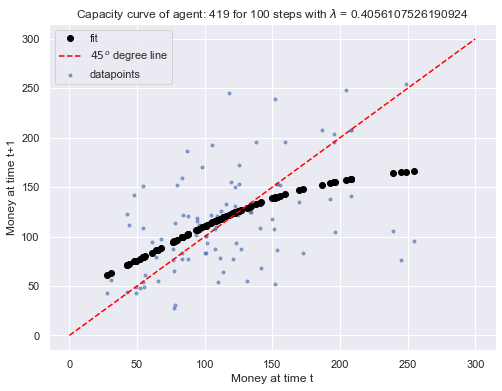

In [52]:
sns.set(rc={'figure.figsize':(8,6)})
plt.plot(xdata, sigmoid(xdata,*popt),'o',color = 'black', label = 'fit')
plt.scatter(xdata,ydata, marker ='.', alpha = '0.6', label = 'datapoints')
plt.title("Capacity curve of agent: {} for {} steps with $\lambda$ = {}".format(agent, steps,lamda))
plt.xlabel("Money at time t")
plt.ylabel("Money at time t+1")
plt.plot([0,300], [0,300], ls = '--', color = 'red', label = '$45^{o}$ degree line')
plt.legend()
plt.savefig("CapacityCurve\Agent{}Steps{}".format(agent, steps))

<h3>Time Series and Wealth Distribution for an agent

In [53]:
#agent = random.randint(0,499)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]

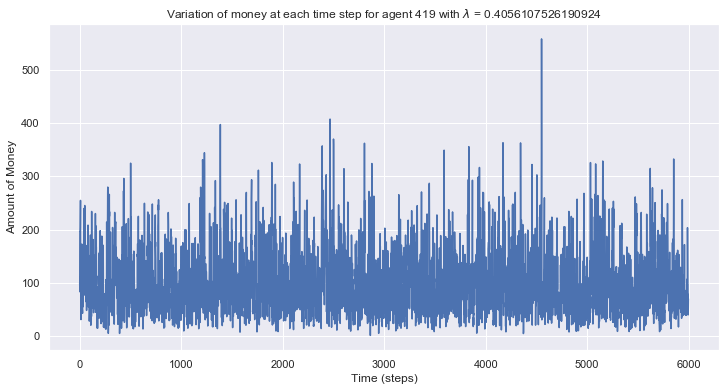

In [54]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(time[0:5999],money[0:5999])
plt.title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
plt.xlabel("Time (steps)")
plt.ylabel("Amount of Money")
plt.savefig("TimeSeries_Lamda{}_Agent{}.png".format(lamda,agent))

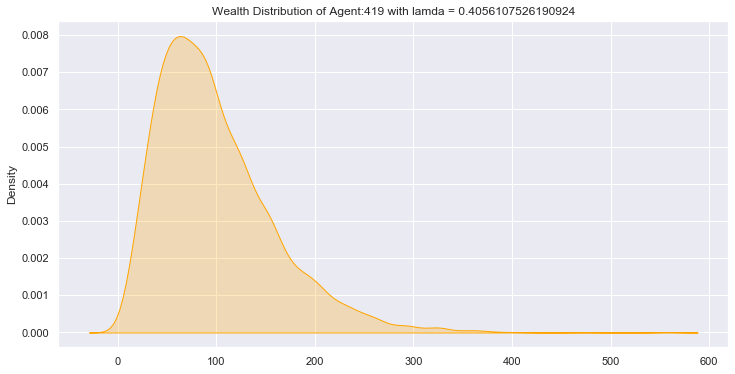

In [55]:
sns.kdeplot(money, fill =True, color = 'orange')
plt.title("Wealth Distribution of Agent:{} with lamda = {}".format(agent, lamda))
plt.savefig("WealthDist_agent{}".format(agent))